In [1]:
from __future__ import print_function

import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,TensorBoard,ReduceLROnPlateau

from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.activations import relu
from tensorflow.keras.regularizers import l2
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import backend as K
# from tensorflow.keras.datasets import mnist, cifar10
import tensorflow_addons as tfa

import sklearn
from itertools import chain

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from scipy.io import loadmat 
import mat73
from datetime import datetime
import ipynbname

print("Packages Loaded")

Packages Loaded


In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      #tf_config = tf.ConfigProto(allow_soft_placement=False)
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
# Use 16bit mmixed precision
#tf.keras.mixed_precision.set_global_policy('mixed_float16')


In [4]:
# wandb login
import wandb
from wandb.keras import WandbCallback
time_stamp = datetime.strftime( datetime.now(),'%d_%B_%y_%H%M')
wandb.init(project="my-test-project", entity="ibksolar", name="OldplainResNet_JanFindpeaks_script_"+time_stamp)

config = wandb.config

wandb: Currently logged in as: ibksolar (use `wandb login --relogin` to force relogin)


In [5]:
# Load data
# raw_data1 = loadmat('new_echo_cnn_in_out_jstarrs2021_first_try/echo_cnn_in_out_jstars1.mat')
# raw_data1 = loadmat('echo_cnn_in_out_GOOD_layers/new_echo_cnn_in_out_jstars1.mat') 'findpeaks_layers/new_echo_cnn_in_out_jstars1.mat'
load_old_data = True

if load_old_data:
    raw_data1 = loadmat('../../../Python_Env/final_layers_rowblock15_21/filtered_image/new_echo_cnn_in_out_jstars1.mat')
    raw_data2 = loadmat('../../../Python_Env/final_layers_rowblock15_21/filtered_image/new_echo_cnn_in_out_jstars2.mat')
    raw_data3 = loadmat('../../../Python_Env/final_layers_rowblock15_21/filtered_image/new_echo_cnn_in_out_jstars3.mat')
    # raw_data4 = loadmat('findpeaks_layers_rowblock20/new_echo_cnn_in_out_jstars4.mat')

    d1 = raw_data1['echo_cnn1']
    t1 = raw_data1['echo_target1']
    i1 = raw_data1['echo_idx1']
    c1 = raw_data1['coords1']

    d2 = raw_data2['echo_cnn2']
    t2 = raw_data2['echo_target2']
    i2 = raw_data2['echo_idx2']
    c2 = raw_data2['coords2']

    d3 = raw_data3['echo_cnn3']
    t3 = raw_data3['echo_target3']
    i3 = raw_data3['echo_idx3']
    c3 = raw_data3['coords3']

    # d4 = raw_data4['echo_cnn4']
    # t4 = raw_data4['echo_target4']
    # i4 = raw_data4['echo_idx4']


    orig_all_data = np.concatenate( (d1,d2,d3),axis = 0 )
    orig_all_target = np.concatenate( (t1,t2,t3),axis = 0 )
    orig_all_idx = np.concatenate( (i1,i2,i3),axis = 0 )
    coords = np.concatenate( (c1,c2,c3),axis = 0 )

    # Set all nan in the data to zero
    nan_idx = np.isnan(orig_all_data).any(axis =-1)
    orig_all_target[nan_idx] = 0
    orig_all_data[ np.isnan(orig_all_data) ]= 0

In [6]:
load_new_data = False
if load_new_data:
    # base_path = '..\\..\\all_block_data\Dec_Train_block_len_21_011121_2331'
    # base_path = '../all_block_data/Old_data/Dec_Train_block_len_21_231121_1531'
    base_path = 'Y:\\ibikunle\\Python_Project\\Fall_2021\\all_block_data\\Attention_Train_data\\Train_data\\20120330_04_5km'
    
    # Confirm path is right...
    print(f'{os.path.isdir(base_path)}')

In [7]:
if load_new_data:
    raw_data1 = mat73.loadmat(base_path + '/echo_cnn_in_out_jstars.mat')
    all_data = raw_data1['echo_cnn_input']
    all_target = raw_data1['echo_cnn_target']
    all_coords = raw_data1['coords']
    echo_idx = raw_data1['orig_echo_idx']

    # Set all nan in the data to zero
    nan_idx = np.isnan(all_data).any(axis =-1)
    print(f' Data have {sum(nan_idx)} nan data points')
    
    all_target[nan_idx] = 0
    all_data[ np.isnan(all_data) ]= 0


    orig_all_data = all_data
    orig_all_target = all_target
    orig_all_idx = echo_idx
    coords = all_coords

In [8]:
# Split based on echograms into small dataset representing training and testing.

config['reduce_test_set'] = False
all_echo_idx = np.unique(orig_all_idx)

# New training should stop at 1225: Final test set starts from echogram 119 in original imb.picker echograms
#test_echo_idx = list(range(1225,int(max(all_echo_idx) +1) ))

# Using pulsed again 13th July, 2022
test_echo_idx = list(chain.from_iterable( [ list(range(20*n+1,20*n+20)) for n in range(1,max(all_echo_idx)//20,2) ] ) )


# list(set(test_echo_idx) & set(train_echo_idx))

if config['reduce_test_set']:    
    test_start = 50 ; test_stop = test_start+round(0.3*len(test_echo_idx))
    test_echo_idx = test_echo_idx[test_start:test_stop]
     
train_echo_idx = [int(elem) for elem in all_echo_idx if elem not in test_echo_idx]

# Create new coords idx for each rowblock from all the echograms
val_cnt = [ (orig_all_idx==elem).sum() for elem in train_echo_idx ]
new_coords = []
for elem in val_cnt:
    new_coords.append([*range(elem)])
new_coords = np.concatenate(new_coords).ravel()

# Get all idx of echos in train_echo_idx ( Might need to find a faster implementation)
#search_idx = np.where(orig_all_idx == train_echo_idx) #np.where( np.in1d(all_idx,train_echo_idx) )
search_idx = []
for echo_idx in train_echo_idx:
    search_idx.append( np.where(orig_all_idx == echo_idx)[0] )
search_idx = list(chain(*search_idx))

all_data = orig_all_data[search_idx]
all_target = orig_all_target[search_idx]
all_idx = orig_all_idx[search_idx]

np.testing.assert_equal(new_coords.shape[0],all_data.shape[0])

In [9]:

truncate_data = False # Truncate data because data after truncate point is not good for training
if truncate_data:    
    echo_idx = np.asarray(echo_idx)
    stop_val = 400

    stop_list, = np.where(echo_idx == stop_val)
    stop_idx = stop_list[-1]

    all_data = all_data[:stop_idx]
    all_target = all_target[:stop_idx]
    echo_idx2 = echo_idx[:stop_idx]

    print(f'Data shape {all_data.shape}')
    print(f'Target shape {all_target.shape}')


In [10]:
config['row_length'] = 21 # CHANGE HERE <==
config['col_length'] = 15

# Check that the dimension of data is correct
if all_data.shape[1] == config['row_length']*config['col_length']:
    print('Dimensions match')
else:
    print(f' Row block length:{config["row_length"]} and col length:{config["col_length"]} does not match Data dimension:{all_data.shape[1]}') 
        

Dimensions match


In [11]:
seq_length = 9

# Create Coords matrix to be used for Positional Embedding
new_coords_mtx = np.zeros( (len(new_coords),seq_length) )

for idx,each_coord in enumerate(new_coords):
    new_coords_mtx[idx] = np.linspace(0, each_coord, num=seq_length)

In [35]:
max_class = config['row_length'] 

# Highest class is mapped to row_length+1
all_target[all_target == max_class+1 ] = 0


shuffle = 1
if shuffle:
    random.Random(13).shuffle(all_data)
    random.Random(13).shuffle(all_target)
    # random.Random(13).shuffle(all_coord_exp)
    random.Random(13).shuffle(new_coords_mtx)

## Prep data
train_size = int(np.floor(0.75*len(all_target)));
test_size = int(np.round( 0.15* all_data.shape[0] ))
val_size = all_data.shape[0] -train_size - test_size

mid_pt = 8
neigh =  4

x_train = all_data[0:train_size,:]
x_train = np.reshape( x_train, (x_train.shape[0],max_class,-1),order ='F' )
x_train = x_train[:,:,mid_pt-neigh:mid_pt+neigh+1]
# x_train = np.reshape(x_train,(x_train.shape[0],-1))
#x_train = np.transpose(x_train,(0,2,1))
coords_train = new_coords_mtx[0:train_size,:]


x_test = all_data[train_size:train_size+test_size,:]
x_test = np.reshape( x_test,(x_test.shape[0],max_class,-1), order ='F' )
x_test = x_test[:,:,mid_pt-neigh:mid_pt+neigh+1]
# x_test = np.reshape(x_test,(x_test.shape[0],-1))
#x_test = np.transpose(x_test,(0,2,1))
coords_test = new_coords_mtx[train_size:train_size+test_size,:]


x_val = all_data[-val_size:,:]
x_val = np.reshape( x_val,(x_val.shape[0],max_class,-1), order ='F' )
x_val = x_val[:,:,mid_pt-neigh:mid_pt+neigh+1]
# x_val = np.reshape(x_val,(x_val.shape[0],-1))
#x_val = np.transpose(x_val,(0,2,1))
coords_val = new_coords_mtx[-val_size:,:]


y_train = all_target[:train_size]
y_test  = all_target[train_size:train_size+test_size]
y_val = all_target[-val_size:]

var_input_shape = x_train.shape[1:] # 240 columns
config['num_classes'] = max_class+1 # layers


# Convert labels to categorical orthonormal vectors
y_train_1hot = tf.keras.utils.to_categorical(y_train, config['num_classes'])
y_test_1hot  = tf.keras.utils.to_categorical(y_test, config['num_classes'])

print(f'Shape of X_train:{x_train.shape}  X_test:{x_test.shape}')
print(f'Shape of y_train:{y_train.shape}  y_test:{y_test.shape}')

Shape of X_train:(831888, 21, 9)  X_test:(166378, 21, 9)
Shape of y_train:(831888, 1)  y_test:(166378, 1)


In [36]:
print(f'Shape of x_val:{x_val.shape}  y_val:{y_val.shape}')

Shape of x_val:(110918, 21, 9)  y_val:(110918, 1)


In [37]:
x_train2 = np.stack((x_train,)*3, axis=-1)
x_test2 = np.stack((x_test,)*3, axis=-1)
x_val2 = np.stack((x_val,)*3, axis=-1)

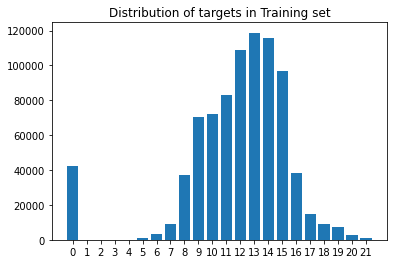

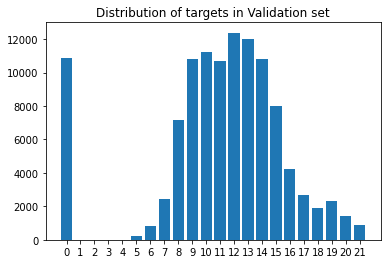

In [15]:
# Show distribution of targets in training and validation set

labels, counts = np.unique(y_train, return_counts=True)
_ = plt.bar(labels, counts, align='center')
_ = plt.gca().set_xticks(labels)
_ = plt.title('Distribution of targets in Training set')
_ = plt.show()


labels, counts = np.unique(y_val, return_counts=True)
_ = plt.bar(labels, counts, align='center')
_ = plt.gca().set_xticks(labels)
_ = plt.title('Distribution of targets in Validation set')
_ = plt.show()

In [38]:
# Populate the param log
base_path =  r'Y:\ibikunle\Python_Project\Fall_2021\all_block_data\PulsedTrainTest\LSTM_PositionalEmbedding'

log ={}
log['Notebook_name'] = ipynbname.name()
log['Uniqueness_of_each_run'] = 'RowBlock retraining in August: No transpose using Old repeated model'
log['base_dir'] = base_path
log['Train_shape'] = x_train.shape
log['Output_shape'] = ''
log['num_epochs'] = ''
log['batch_size'] = ''
log['activation_function'] = ''
log['optimizer'] = ''
log['learning_rate'] = ''
log['loss_finction'] = ''
log['accuracy'] = []
log['loss'] = []
log['stop_time'] = ''
log['Model_config'] = ''
log['Performance_on_test_set'] = ''
log['output_path'] = ''  # output: where the trained model is saved
log['shuffle'] = shuffle
log['run_completion_comment'] = '' # Comment on training and probably evaluation too
log['extras'] = []

from model_hyper_param_log import create_log_entry,update_log_entry
if "log_idx" in globals():
    log["S_N"] = log_idx
log_idx = create_log_entry('../testing_sheet2.xlsx', log)

Could not get file name: auto-generating name
Activation_function not in workspace
loss_function not in workspace
Accuracy_per_epoch not in workspace
Loss_per_epoch not in workspace
Stop_time not in workspace
Current run hyper_params are dict_keys(['S_N', 'Start_time', 'NoteBook_name', 'Uniqueness_of_each_run', 'Base_dir', 'Train_shape', 'Output_shape', 'num_epochs', 'Activation_function', 'optimizer', 'learning_rate', 'loss_function', 'Accuracy_per_epoch', 'Loss_per_epoch', 'Stop_time', 'Model_config', 'Performance_on_test_set', 'output_path', 'shuffle', 'Computer_name', 'extras']):dict_values([95, '06_August_22_2312', 'NewDataset_ConvResNetRowBlock', 'RowBlock retraining in August: No transpose using Old repeated model', 'Y:\\ibikunle\\Python_Project\\Fall_2021\\all_block_data\\PulsedTrainTest\\LSTM_PositionalEmbedding', (831888, 21, 9), '', '', '', '', '', '', '', '', '', '', '', '', 1, 'DESKTOP-9ME1LSE', []])
Fields to be updated include: ['Activation_function', 'loss_function', 'A

In [17]:
data_augmentation = tf.keras.Sequential(
    [
        #layers.Rescaling(1 / 255.0),        
        layers.RandomCrop(x_train.shape[1], x_train.shape[2]),
        layers.RandomFlip("vertical"),
        layers.RandomFlip("horizontal"),
        layers.RandomContrast(0.2),
        
    ],
    name="data_augmentation",
)

In [39]:
# Create your own ResNet here.

# Skip 3 connection version of base model
drop_out = 0.2
nodes = 1024
num_epochs = 300
batch_size= 128 #512
learning_rate = 1e-3

input_shape = (x_train2.shape[1:])# + (1,) #input_shape = (21,5,) #x_train.shape[2]
inputs = tf.keras.Input(shape=input_shape, name='Data_Input') 

# pos_input_shape = (coords_train.shape[1:])
# pos_inputs = tf.keras.Input(shape= pos_input_shape, name='PosEmbed_Input')
# pos_embedding = layers.Embedding(input_dim = np.max(new_coords), output_dim = input_shape[-1])(pos_inputs)

x1 = data_augmentation(inputs) #+ pos_embedding
x1 = tf.reduce_mean(x1, axis =-1)
x2 = layers.LayerNormalization()(x1)

x2 = layers.Conv1D(64,3,activation="relu",input_shape=(x1.shape[-2:]),padding="same")(x1)
x2 = layers.Conv1D(64,3,activation="relu",input_shape=(x1.shape[-2:]),padding="same")(x2)

x2 = layers.Flatten()(x2)

# aug_inputs = data_augmentation(inputs)
#x = Dense(nodes, activation='relu')(inputs)

block_1_output = Dense(nodes)(x2) #activation='relu'
x = Dense(nodes,activation='relu')(block_1_output)
x = BatchNormalization()(x)
# x = Activation('relu')(x)
# x = Dropout(drop_out)(x)

x = Dense(nodes)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(drop_out)(x)

x = Dense(nodes)(x)
x = BatchNormalization()(x)

block_2_output = tf.keras.layers.add([x, block_1_output])

x = Dense(nodes,activation='relu')(block_2_output)
x = BatchNormalization()(x)
# x = Activation('relu')(x)
# x = Dropout(drop_out)(x)
x = Dense(nodes)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(drop_out)(x)
x = Dense(nodes)(x)
x = BatchNormalization()(x)

block_3_output = tf.keras.layers.add([x, block_2_output, block_1_output])

x = Dense(nodes,activation='relu')(block_3_output)
x = BatchNormalization()(x)
# x = Activation('relu')(x)
# x = Dropout(drop_out)(x)
x = Dense(nodes)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(drop_out)(x)
x = Dense(nodes)(x)
x = BatchNormalization()(x)

block_4_output = tf.keras.layers.add([x, block_3_output, block_2_output])

x = Dense(nodes,activation='relu')(block_4_output)
x = BatchNormalization()(x)
# x = Activation('relu')(x)
# x = Dropout(drop_out)(x)
x = Dense(nodes)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(drop_out)(x)
x = Dense(nodes)(x)
x = BatchNormalization()(x)

block_5_output = tf.keras.layers.add([x, block_4_output, block_3_output])


x = Dense(nodes,activation='relu')(block_5_output)
x = BatchNormalization()(x)
# x = Activation('relu')(x)
# x = Dropout(drop_out)(x)
x = Dense(nodes)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(drop_out)(x)
x = Dense(nodes)(x)
x = BatchNormalization()(x)

block_6_output = tf.keras.layers.add([x, block_5_output, block_4_output])

# x = Dense(nodes)(block_6_output)
# x = BatchNormalization()(x)
# x = Activation('relu')(x)
# x = Dropout(drop_out)(x)
# x = Dense(nodes)(x)
# x = BatchNormalization()(x)
# x = Activation('relu')(x)
# x = Dropout(drop_out)(x)
# x = Dense(nodes)(x)
# x = BatchNormalization()(x)

# block_7_output = tf.keras.layers.add([x,block_6_output, block_5_output])

# x = Dense(nodes)(block_7_output)
# x = BatchNormalization()(x)
# x = Activation('relu')(x)
# x = Dropout(drop_out)(x)
# x = Dense(nodes)(x)
# x = BatchNormalization()(x)
# x = Activation('relu')(x)
# x = Dropout(drop_out)(x)
# x = Dense(nodes)(x)
# x = BatchNormalization()(x)

# block_8_output = tf.keras.layers.add([x, block_7_output,block_6_output])

# x = Dense(nodes)(block_8_output)
# x = BatchNormalization()(x)
# x = Activation('relu')(x)
# x = Dropout(drop_out)(x)
# x = Dense(nodes)(x)
# x = BatchNormalization()(x)
# x = Activation('relu')(x)
# x = Dropout(drop_out)(x)
# x = Dense(nodes)(x)
# x = BatchNormalization()(x)

# block_9_output = tf.keras.layers.add([x, block_8_output, block_7_output])

# x = Dense(nodes)(block_9_output)
# x = BatchNormalization()(x)
# x = Activation('relu')(x)
# x = Dropout(drop_out)(x)
# x = Dense(nodes)(x)
# x = BatchNormalization()(x)
# x = Activation('relu')(x)
# x = Dropout(drop_out)(x)
# x = Dense(nodes)(x)
# x = BatchNormalization()(x)

block_10_output = tf.keras.layers.add([x, block_6_output, block_1_output])


x = Dense(nodes, activation='relu')(block_10_output)
x = Dropout(drop_out)(x)
outputs = Dense(config['num_classes'], activation='softmax', activity_regularizer='l2')(x)

model = tf.keras.Model(inputs, outputs, name='Plain_Old_Resnet')

top_K = 3
weight_decay = 0.0001
opt1 = tfa.optimizers.AdamW(learning_rate=learning_rate, weight_decay=weight_decay) #Adam(amsgrad=True)
opt2 = Adam(learning_rate=learning_rate,amsgrad=True)

model.compile("Nadam", loss="categorical_crossentropy" , metrics=['accuracy',tf.keras.metrics.TopKCategoricalAccuracy(top_K, name="top-3-accuracy")])  #label_smoothing=0.05, tf.keras.losses.KLDivergence()
#"categorical_crossentropy",tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2)
wandb.config = {
  "learning_rate": "learning_rate",
  "epochs": num_epochs,
  "batch_size": batch_size,
  "nodes": nodes,  
  "base_path":base_path,
  "shuffle":shuffle
}


start_time = datetime.strftime( datetime.now(),'%d_%B_%y_%H_%M');
print(f'Training start time{start_time}')

callbacks = [
    ModelCheckpoint(base_path+'/'+ipynbname.name()+"/best_model"+start_time+".h5", save_best_only=True, monitor="val_loss"),
    ReduceLROnPlateau(monitor="val_loss", factor=0.25, patience=10,verbose=1, min_lr=0.00001),
    EarlyStopping(monitor="val_loss", patience=30, verbose=1), 
    WandbCallback()
]


#TO DO: Would normalizing with from sklearn.preprocessing import MinMaxScaler help? Try later
history = model.fit(x_train2, y_train_1hot,
          epochs= num_epochs, 
          batch_size= batch_size, 
          validation_data=(x_test2, y_test_1hot), callbacks = callbacks)  #mcp_save, callbacks=[reduce_lr_loss]

# Update manual log file
params_to_be_updated = update_log_entry('../testing_sheet2.xlsx', log_idx, model, history)


# Update model with the best weights
model = tf.keras.models.load_model(base_path+'/'+ipynbname.name()+"/best_model"+start_time+".h5") # base_path+'/'+ipynbname.name()+"/best_model.h5"

end_time = datetime.strftime( datetime.now(),'%d_%B_%y_%H_%M')
print(f'End time {end_time}')

Training start time06_August_22_23_13
Epoch 1/300
6500/6500 [==============================] - 552s 84ms/step - loss: 1.8627 - accuracy: 0.3364 - top-3-accuracy: 0.7082 - val_loss: 2.4704 - val_accuracy: 0.1808 - val_top-3-accuracy: 0.5615 - lr: 0.0010 - _timestamp: 1659846139.0000 - _runtime: 199667.0000
Epoch 2/300
6500/6500 [==============================] - 550s 85ms/step - loss: 1.7399 - accuracy: 0.3589 - top-3-accuracy: 0.7396 - val_loss: 2.3605 - val_accuracy: 0.2961 - val_top-3-accuracy: 0.6336 - lr: 0.0010 - _timestamp: 1659846690.0000 - _runtime: 200218.0000
Epoch 3/300
6500/6500 [==============================] - 549s 84ms/step - loss: 1.7099 - accuracy: 0.3654 - top-3-accuracy: 0.7453 - val_loss: 8.6765 - val_accuracy: 0.1400 - val_top-3-accuracy: 0.3913 - lr: 0.0010 - _timestamp: 1659847238.0000 - _runtime: 200766.0000
Epoch 4/300
6500/6500 [==============================] - 550s 85ms/step - loss: 1.7028 - accuracy: 0.3659 - top-3-accuracy: 0.7465 - val_loss: 2.7065 - val

ValueError: Must have equal len keys and value when setting with an iterable

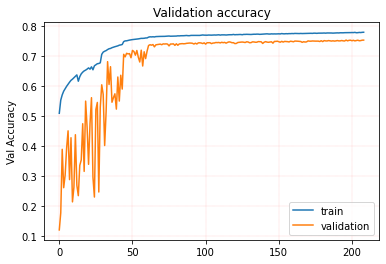

In [30]:
def PlotCurves(model_history):
    plt.plot(model_history.history['accuracy'],label = 'train')
    plt.grid(color = 'r', linestyle = '--', linewidth = .1)
    plt.ylabel('Accuracy');
    plt.title('Training accuracy');
    #plt.figure()
    plt.plot(model_history.history['val_accuracy'],label = 'validation')
    plt.grid(color = 'r', linestyle = '--', linewidth = .1)
    plt.ylabel('Val Accuracy');
    plt.title('Validation accuracy');
    plt.legend()
    return None

PlotCurves(history)

In [31]:
log['Uniqueness_of_each_run'] = 'Added Conv1D to existing ConvResNet'
run_completion_comment = f'July2022: Used pulsed dataset and data augmentation for ResNet'
if "log_idx" in globals():
    log["S_N"] = log_idx
    log['run_completion_comment'] = run_completion_comment
    log_idx = create_log_entry('../testing_sheet2.xlsx', log)

Could not get file name: auto-generating name
Activation_function not in workspace
loss_function not in workspace
Accuracy_per_epoch not in workspace
Loss_per_epoch not in workspace
Stop_time not in workspace
Current run hyper_params are dict_keys(['S_N', 'Start_time', 'NoteBook_name', 'Uniqueness_of_each_run', 'Base_dir', 'Train_shape', 'Output_shape', 'num_epochs', 'Activation_function', 'optimizer', 'learning_rate', 'loss_function', 'Accuracy_per_epoch', 'Loss_per_epoch', 'Stop_time', 'Model_config', 'Performance_on_test_set', 'output_path', 'shuffle', 'Computer_name', 'extras']):dict_values([95, '06_August_22_2302', 'NewDataset_ConvResNetRowBlock', 'Added Conv1D to existing ConvResNet', 'Y:\\ibikunle\\Python_Project\\Fall_2021\\all_block_data\\PulsedTrainTest\\LSTM_PositionalEmbedding', (831888, 9, 21), '', '', '', '', '', '', '', '', '', '', '', '', 1, 'DESKTOP-9ME1LSE', []])
Fields to be updated include: ['Activation_function', 'loss_function', 'Accuracy_per_epoch', 'Loss_per_epo

In [32]:
y_val_1hot  = tf.keras.utils.to_categorical(y_val, config['num_classes'])

_, accuracy,top_5_accuracy = model.evaluate(x_val2, y_val_1hot)
print(f"Test accuracy: {round(accuracy * 100, 2)}%")
print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

time_stamp = datetime.strftime( datetime.now(),'%d_%B_%y_%H_%M');

#_,new_col_length,new_row_length = x_train.shape 
model.save(f'{base_path}//{ipynbname.name()}//{time_stamp}_Acc_{accuracy:.3f}_Top5Acc_{top_5_accuracy:.3f}_315x1.h5')

3467/3467 [==============================] - 44s 13ms/step - loss: 2.0691 - accuracy: 0.6871 - top-3-accuracy: 0.8911
Test accuracy: 68.71%
Test top 5 accuracy: 89.11%


In [75]:

import random
check_start = random.randint(0,len(x_val))

print(f'Check start idx: {check_start}')
[(np.argmax(y_val_1hot[idx]), np.argmax(model.predict(np.expand_dims(x_val2[idx],axis=0))) ) for idx in range(check_start,check_start+20) ]


Check start idx: 77394


[(0, 0),
 (12, 12),
 (12, 12),
 (19, 13),
 (0, 12),
 (0, 0),
 (7, 10),
 (11, 11),
 (15, 15),
 (9, 9),
 (21, 19),
 (8, 8),
 (18, 15),
 (9, 9),
 (14, 14),
 (9, 10),
 (14, 14),
 (19, 19),
 (14, 13),
 (11, 11)]

In [76]:
# Test model manually on all val data

y_pred = [ np.argmax(model.predict(np.expand_dims(x_val2[idx],axis=0) )) for idx in range(len(x_val)) ]

combined_result = zip(y_val,y_pred)

val_exact_accuracy = 100 * sum([1 if y_pred[idx]==y_val[idx]   else 0 for idx in range(len(y_pred)) ]) / len(y_pred)
val_margin5_accuracy = 100 * sum([1 if abs(y_pred[idx]-y_val[idx]) < 3 else 0 for idx in range(len(y_pred)) ]) / len(y_pred)

print(f' Exact accuracy is {val_exact_accuracy: .5f} %')
print(f' Top 3% accuracy is {val_margin5_accuracy: .5f} %')



 Exact accuracy is  69.17993 %
 Top 3% accuracy is  80.19438 %


In [77]:
# Confusion Matrix and ROC/AUC

model_predictions = np.asarray(y_pred)
ground_truth = y_val.squeeze()

# Prediction per Ground-truth class
class_predictions = [ model_predictions[ground_truth==idx]  for idx in range(config['num_classes']) ]

# Confusion matrix
confusion_mtx = np.zeros((config['num_classes'],config['num_classes']) )

for pred,actual in zip(y_pred,y_val): # Rows=Prediction, Columns = Actual
    confusion_mtx[pred,actual] +=1

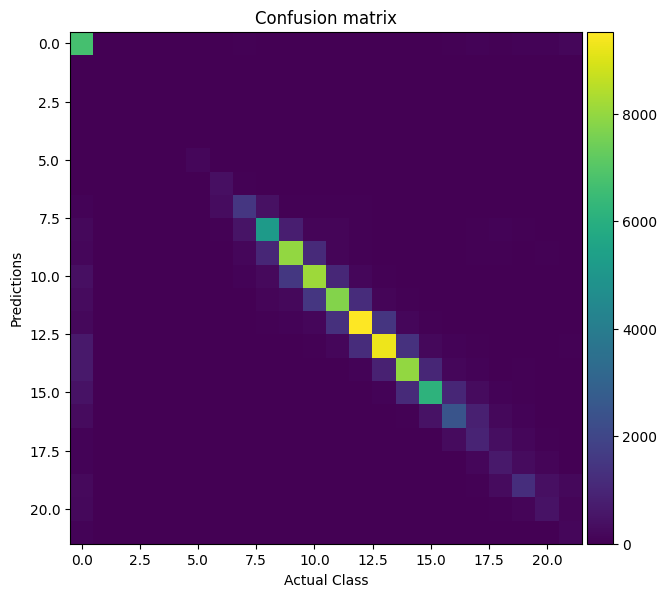

In [78]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(figsize=(7,15),dpi = 100);
shw=ax.imshow(confusion_mtx)
#bar= plt.colorbar(shw)

_=plt.ylabel('Predictions')
_=plt.xlabel('Actual Class')
_=plt.title('Confusion matrix')

# ax.set_xticklabels(list(range(num_classes)))
# ax.set_yticklabels(list(range(num_classes)))

# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
#bar.set_label('ColorBar')
_ = plt.colorbar(shw, cax=cax)

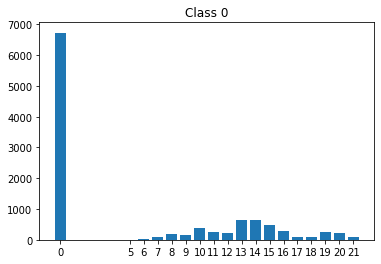

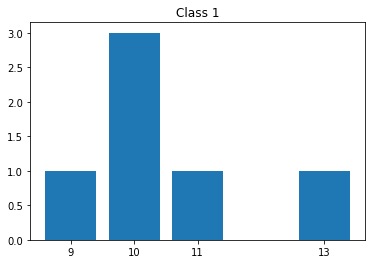

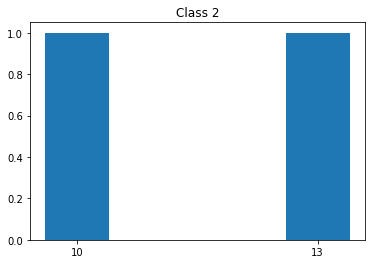

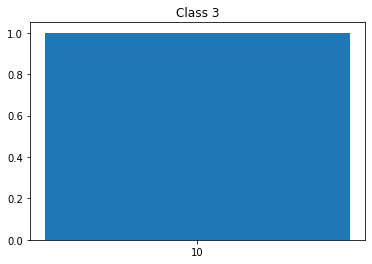

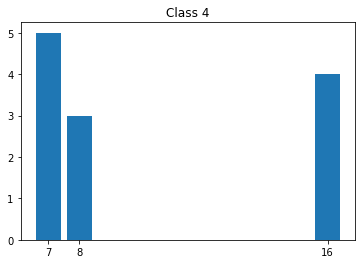

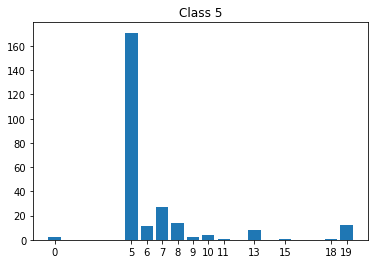

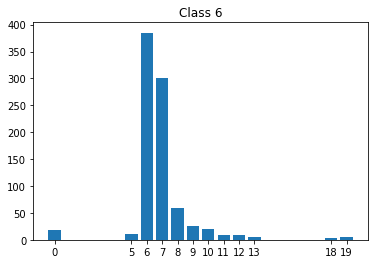

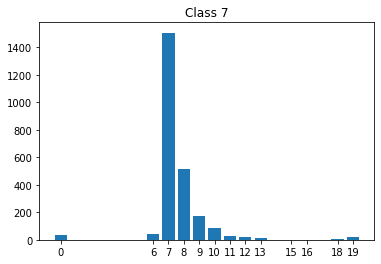

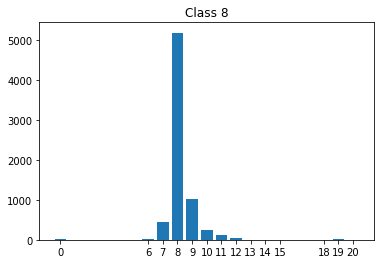

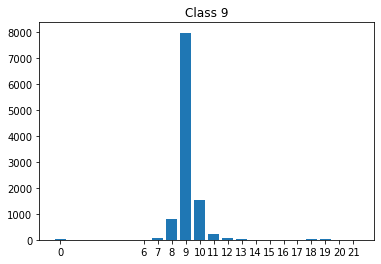

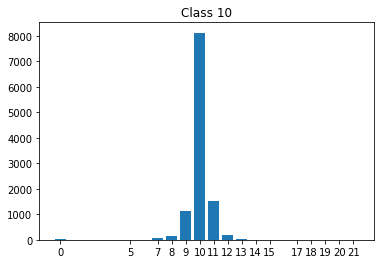

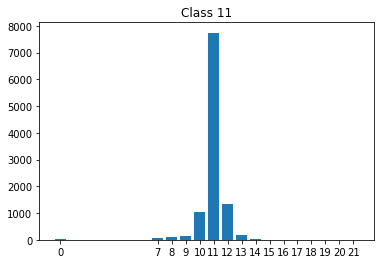

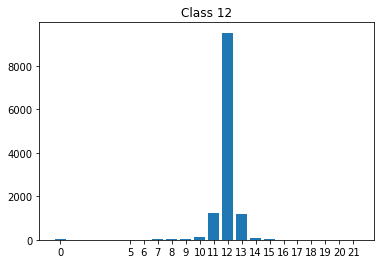

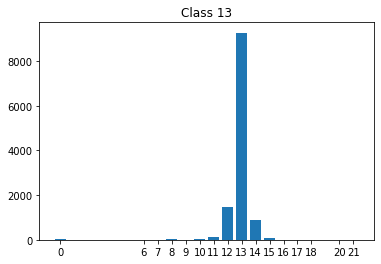

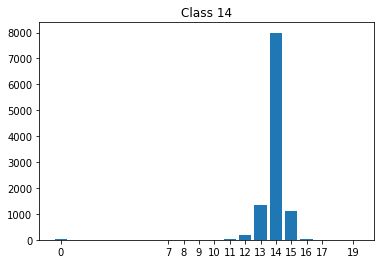

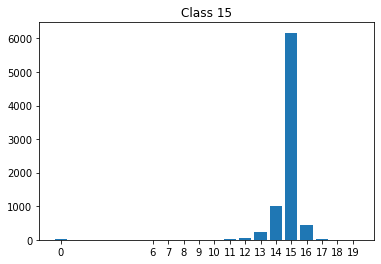

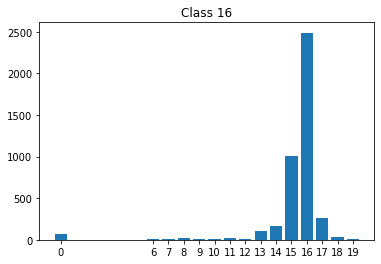

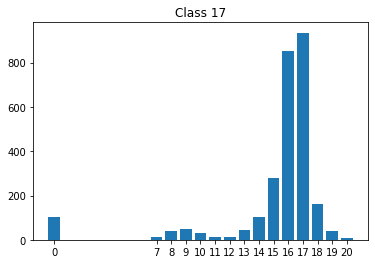

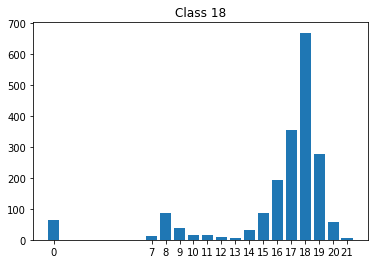

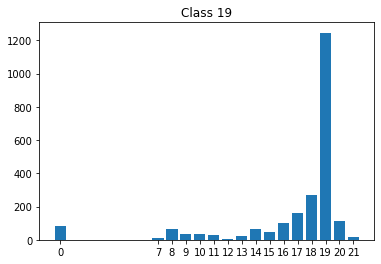

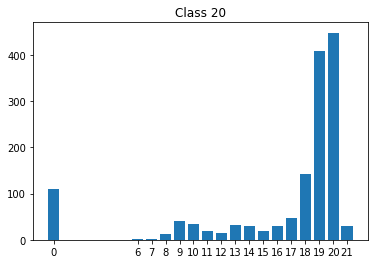

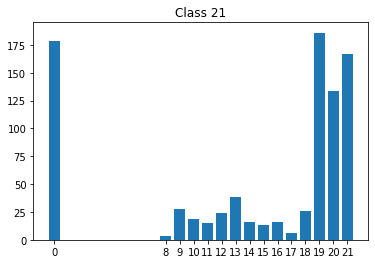

In [79]:
# Histogram of each class prediction
for idx,each_class in enumerate(class_predictions):
    _ = plt.figure()
    _ = plt.title('Class %s'%idx)
    labels, counts = np.unique(each_class, return_counts=True)
    _ = plt.bar(labels, counts, align='center')
    _ = plt.gca().set_xticks(labels)
    _ = plt.show()

In [52]:
# Check model on unseen data from 20120330_04

test_cnt = [ (orig_all_idx==elem).sum() for elem in test_echo_idx]
test_coords = []
for elem in test_cnt:
    test_coords.append([*range(elem)])
test_coords = np.concatenate(test_coords).ravel()

# Get all idx of echos in train_echo_idx
val_search_idx = np.where(orig_all_idx == test_echo_idx) #np.where( np.in1d(all_idx,train_echo_idx) )
val_search_idx = list(val_search_idx[0])

test_data = orig_all_data[val_search_idx]
test_target = orig_all_target[val_search_idx]
test_idx = orig_all_idx[val_search_idx]

In [ ]:
from sklearn.metrics import classification_report

print( classification_report( y_val,y_pred, labels=list(range(config['num_classes'])), zero_division=1 ))

In [57]:
# Reshape and prepare unseen test_data

test_data = np.reshape( test_data, (test_data.shape[0],max_class,-1),order ='F' )
test_data = test_data[:,:,mid_pt-neigh:mid_pt+neigh+1]
# x_train = np.reshape(x_train,(x_train.shape[0],-1))
test_data = np.transpose(test_data,(0,2,1))
test_target[test_target == max_class+1 ] = 0

In [54]:
seq_length = 9

# Create Coords matrix to be used for Positional Embedding
test_coords_mtx = np.zeros( (len(test_coords),seq_length) )

for idx,each_coord in enumerate(test_coords):
    test_coords_mtx[idx] = np.linspace(0, each_coord, num=seq_length)

In [24]:
test_data2 = np.stack((test_data,)*3, axis=-1) 

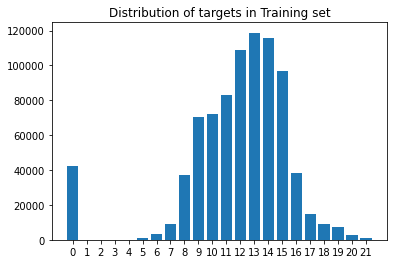

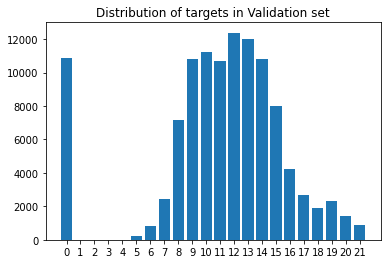

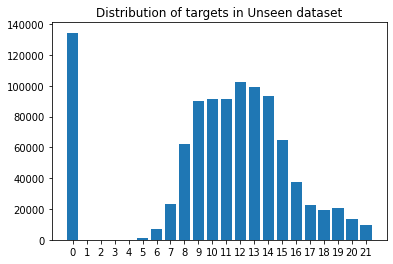

In [84]:
# Show distribution of targets in training and validation set

labels, counts = np.unique(y_train, return_counts=True)
_ = plt.bar(labels, counts, align='center')
_ = plt.gca().set_xticks(labels)
_ = plt.title('Distribution of targets in Training set')
_ = plt.show()


labels, counts = np.unique(y_val, return_counts=True)
_ = plt.bar(labels, counts, align='center')
_ = plt.gca().set_xticks(labels)
_ = plt.title('Distribution of targets in Validation set')
_ = plt.show()


labels, counts = np.unique(test_target, return_counts=True)
_ = plt.bar(labels, counts, align='center')
_ = plt.gca().set_xticks(labels)
_ = plt.title('Distribution of targets in Unseen dataset')
_ = plt.show()

In [85]:
# Convert labels to categorical orthonormal vectors
test_target_1hot = tf.keras.utils.to_categorical(test_target, config['num_classes'])

time_stamp = datetime.strftime(datetime.now(),'%d_%B_%y_%H%M')
_, accuracy,top3_acc = model.evaluate(test_data2, test_target_1hot)
print(f"Test accuracy: {round(accuracy * 100, 2)}%")
print(f"Test top 3 accuracy: {round(top3_acc * 100, 2)}%")
print(f"Test_time: {datetime.strftime(datetime.now(),'%d_%B_%y_%H%M')}")



30788/30788 [==============================] - 512s 17ms/step - loss: 4.1644 - accuracy: 0.5251 - top-3-accuracy: 0.8286
Test accuracy: 52.51%
Test top 3 accuracy: 82.86%
Test_time: 21_July_22_1436


In [41]:

import random
check_start = random.randint(0,len(test_target))

print(f'Check start idx: {check_start}')
[(np.argmax(test_target_1hot[idx]), np.argmax(model.predict(np.expand_dims(test_data[idx],axis=0))) ) for idx in range(check_start,check_start+20) ]


Check start idx: 697850


[(10, 10),
 (10, 10),
 (10, 10),
 (10, 10),
 (10, 10),
 (10, 10),
 (18, 13),
 (18, 13),
 (18, 13),
 (18, 16),
 (19, 16),
 (19, 17),
 (19, 17),
 (19, 17),
 (19, 17),
 (18, 17),
 (18, 17),
 (18, 17),
 (18, 17),
 (18, 17)]

In [64]:
# Test model manually on all val data

test_pred = [ np.argmax(model.predict(np.expand_dims(test_data[idx],axis=0) )) for idx in range(len(test_target)) ]

combined_result = zip(test_target,test_pred)

val_exact_accuracy = 100 * sum([1 if test_pred[idx]==test_target[idx]   else 0 for idx in range(len(test_pred)) ]) / len(test_pred)
val_margin3_accuracy = 100 * sum([1 if abs(test_pred[idx]-test_target[idx]) < 3 else 0 for idx in range(len(test_pred)) ]) / len(test_pred)

print(f' Exact accuracy is {val_exact_accuracy: .5f} %')
print(f' Top 3% accuracy is {val_margin3_accuracy: .5f} %')



 Exact accuracy is  74.26402 %
 Top 3% accuracy is  80.85811 %


In [ ]:
# Confusion Matrix and ROC/AUC

model_predictions = np.asarray(test_pred)
ground_truth = test_target.squeeze()

# Prediction per Ground-truth class
class_predictions = [ model_predictions[ground_truth==idx]  for idx in range(config['num_classes']) ]

# Confusion matrix
confusion_mtx = np.zeros((config['num_classes'],config['num_classes']) )

for pred,actual in zip(test_pred,test_target): # Rows=Prediction, Columns = Actual
    confusion_mtx[pred,actual] +=1

In [ ]:
entire_data = raw_data1['echo_cnn_input']
entire_target = raw_data1['echo_cnn_target']
entire_coords = raw_data1['coords']
entire_idx = raw_data1['orig_echo_idx']

entire_target[entire_target == num_classes] = 0 # Map highest class back to "No_layer" class
entire_target  = tf.keras.utils.to_categorical(entire_target, num_classes)


In [ ]:

# Check random entire_data prediction
check_start = random.randint(0,len(entire_data))

print(f'Check start idx: {check_start}')
[(np.argmax(entire_target[idx]), np.argmax(model.predict(np.expand_dims(entire_data[idx],axis=0))) ) for idx in range(check_start,check_start+20) ]


In [ ]:
# Train ResNet2 model further (100 epochs more??)

extra_epochs = 100

history2 = model.fit(x_train, y_train,
          epochs= extra_epochs, 
          batch_size= batch_size, 
          validation_data=(x_test, y_test), callbacks=callbacks) #mcp_save, callbacks=[reduce_lr_loss]
 


In [ ]:
# Check random entire_data prediction after training further
check_start = random.randint(0,len(entire_data))

print(f'Check start idx: {check_start}')
[(np.argmax(entire_target[idx]), np.argmax(model.predict(np.expand_dims(entire_data[idx],axis=0))) ) for idx in range(check_start,check_start+20) ]


In [ ]:
# Define Sequential model with 3 layers
num_epochs = 100
batch_size = 64
nodes = 256
learning_rate = 1e-4

wandb.config = {
  "learning_rate": "learning_rate",
  "epochs": num_epochs,
  "batch_size": batch_size,
  "nodes": nodes,
  "row_length":row_length,
  "base_path":base_path,
  "shuffle":shuffle

}

input_shape = x_train.shape[1:] #(21,15,1)

def ResNetBlock(x):
    x =   layers.Conv2D(filters=64, kernel_size=3, padding="same")(x) #input_layer
    conv1 = layers.Conv2D(filters=64, kernel_size=3, padding="same")(x) # input_layer, Conv1D
    conv1 = layers.BatchNormalization()(conv1)
    conv1 = layers.ReLU()(conv1)

    conv2 = layers.Conv2D(filters=64, kernel_size=3, padding="same")(conv1)
    conv2 = layers.BatchNormalization()(conv2)
    conv2 = layers.ReLU()(conv2)

    conv3 = layers.Conv2D(filters=64, kernel_size=3, padding="same")(conv2)
    conv3 = layers.BatchNormalization()(conv3)
    conv3 = layers.ReLU()(conv3)
    
    
    conv3 = layers.Conv2D(filters=64, kernel_size=3, padding="same")(conv2)
    conv3 = layers.BatchNormalization()(conv3)
    conv3 = layers.ReLU()(conv3)
    
    
    conv3 = layers.Conv2D(filters=64, kernel_size=3, padding="same")(conv2)
    conv3 = layers.BatchNormalization()(conv3)
    conv3 = layers.ReLU()(conv3)
    
    conv3 = layers.add([x,conv3])
    x = layers.ReLU()(conv3) # Overwrite x
    
    return x


def make_model(input_shape):
    input_layer = layers.Input(input_shape)
    
    x =   layers.Conv2D(filters=64, kernel_size=3, padding="same")(input_layer)
    
    for _ in range(20):
        x = ResNetBlock(x)
    
    # conv1 = layers.Conv2D(filters=64, kernel_size=3, padding="same")(input_layer) #Conv1D
    # conv1 = layers.BatchNormalization()(conv1)
    # conv1 = layers.ReLU()(conv1)
    # conv2 = layers.Conv2D(filters=64, kernel_size=3, padding="same")(conv1)
    # conv2 = layers.BatchNormalization()(conv2)
    # conv2 = layers.ReLU()(conv2)
    # conv3 = layers.Conv2D(filters=64, kernel_size=3, padding="same")(conv2)
    # conv3 = layers.BatchNormalization()(conv3)
    # conv3 = layers.ReLU()(conv3)
    
    gap = layers.GlobalAveragePooling2D()(x)
    gap = layers.Flatten()(gap)

    output_layer = layers.Dense(num_classes, activation="softmax")(gap)

    return tf.keras.models.Model(inputs=input_layer, outputs=output_layer)

model = make_model(input_shape = input_shape) #x_train.shape[1:]


callbacks = [
    ModelCheckpoint("best_model.h5", save_best_only=True, monitor="val_loss"),
    ReduceLROnPlateau(monitor="val_loss", factor=0.25, patience=5, min_lr=0.0001),
    EarlyStopping(monitor="val_loss", patience=25, verbose=1), 
    WandbCallback()
]


# Poly Rate scheduler
starter_learning_rate = 0.1
end_learning_rate = 0.001
decay_steps = 1000
learning_rate_fn = tf.keras.optimizers.schedules.PolynomialDecay(
    starter_learning_rate,
    decay_steps,
    end_learning_rate,
    power=0.5)

# opt1 = tf.keras.optimizers.RMSprop(learning_rate=0.1,rho=0.9,momentum=0.9, epsilon=1e-07,centered=True,name="RMSprop")
opt2 = tf.keras.optimizers.Adam(learning_rate=learning_rate,amsgrad=True)
poly_rate = tf.keras.optimizers.SGD(learning_rate = learning_rate_fn)
poly_rate2 = tf.keras.optimizers.Adam(learning_rate = learning_rate_fn)

# top_K = 3
# model.compile( optimizer = opt, loss= 'categorical_crossentropy', metrics=['accuracy',tf.keras.metrics.TopKCategoricalAccuracy(top_K, name="top-3-accuracy")])  #label_smoothing=0.05, tf.keras.losses.KLDivergence()

model.compile( optimizer=poly_rate2,loss="categorical_crossentropy", metrics=["accuracy"],) #sparse_categorical_accuracy


history = model.fit(x_train, y_train,
          epochs= num_epochs, 
          batch_size= batch_size, 
          validation_data=(x_test, y_test),
         callbacks=callbacks) #mcp_save, callbacks=[reduce_lr_loss]



In [ ]:
_, accuracy = model.evaluate(x_val, y_val)
print(f"Test accuracy: {round(accuracy * 100, 2)}%")
# print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

_,new_col_length,new_row_length = x_train.shape 
model.save(f'{base_path}//{ipynbname.name()}//{time_stamp}_Acc_{accuracy:.3f}_{new_row_length}x{new_col_length}.h5')